# ライブラリのインポート


In [1]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# データセットの作成

In [81]:
#入力画像の前処理をするクラス
#訓練時と推論時で処理が異なる

class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時に異なる動作をする　
    
    
    """
    
    def __init__(self , resize , mean , std):
        self.data_transform = {
            'train':transforms.Compose([
                transforms.RandomResizedCrop(resize , scale = (0.5 ,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean , std)
            ]),
            'val':transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean , std)
             ])
            
        }
    
    
    def __call__(self , img , phase='train'):
        """"
        
        """
        
        return self.data_transform[phase](img)
    
    
    

ImageTransformを訓練時に実行した時の動作を確認します。
<br>
犬の顔が切り取られて、横に伸ばされて、さらに左右に反転しています。結果は実行するたびに変化します。


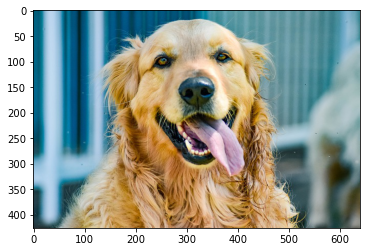

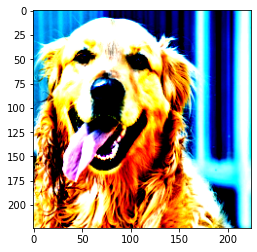

In [82]:
# 訓練時の画像前処理動作の確認

#画像の読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) #[高さ][幅][色RGB]


# 元の画像の表示
plt.imshow(img)
plt.show()

# 画像の前処理と処理済画像の表示
size = 224
mean = (0.485 , 0.456 , 0.406)
std = (0.229 , 0.224 , 0.225)

transform = ImageTransform(size, mean , std)
img_transformed = transform(img , phase = 'train')

# (色、高さ　、幅)を（高さ、幅、色）に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed , 0 ,1)
plt.imshow(img_transformed)
plt.show()

次にデータへファイルパスを格納したリスト型変数を作成します。
<br>
訓練データ、検証データに対応したファイルパスのリストをそれぞれ作成します。
<br>
ファイルパスの文字列をosp.joinで作成し、globでファイルパスを取得します。

In [83]:
# アリとハチの画像へのファイルパスを作成する

def make_datapath_list(phase='train'):
    """""
    データのパスを格納したリストを作成する。
    
    Paramerters
    ------------------
    phase: 'train' or 'val'
          訓練データか検証データかを指定する。
          
          
    Return    
    ------------------
    path_list :list
          データへのパスを格納したリスト
    
    """
    
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list =[]    #ここに格納する
    
    
     #globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)
            
    return path_list


# 実行
train_list = make_datapath_list(phase = 'train')
val_list = make_datapath_list(phase = 'val')

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg',
 './data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg',
 './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 './data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg',
 './data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg',
 './data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg',
 './data/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg',
 './data/hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg',
 './data/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 './data/hymenoptera_data/train/bees/266644509_d30bb16a1b.jpg',
 './data/hymenoptera_data/train/bees/2470492904_837e97800d.jpg',
 './data/hymenoptera_data/train/bees/2053200300_8911ef438a.jpg',
 './data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 './data/hymenoptera_data/train/bees/473618094_8ffdcab215.jpg',
 './data/hymenoptera_data/train/bees/150013791_969d9a968b.jpg',
 './data/hymenoptera_data/trai

最後にDatasetのクラスを作成し、訓練データと検証データについてそれぞれのインスタンスを作成します。
<br>
アリの場合はlabelを0とし、ハチの場合はlabelを1とします。Datasetクラスを継承したオリジナルのデータセットを作る際は、Datasetから1つのデータを取り出すメソッドの__len__()を実装する必要があります。

In [84]:
# アリとハチの画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # ラベルを数値に変更する
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
1


## DataLoaderを作成

Datasetを使用してDataLoaderを作成します。訓練用のDataLoaderはshuffle=Trueと設定し、画像を取り出す順番がランダムになるようにします。

In [112]:
#ミニバッチのサイズを指定
batch_size = 32

#DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
train_dataset , batch_size=batch_size , shuffle = True)

val_dataloader = torch.utils.data.DataLoader(
val_dataset , batch_size=batch_size , shuffle = False)


#辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader , "val" : val_dataloader}

#動作確認
batch_iterator = iter(dataloaders_dict["train"]) #イテレータに変換
inputs , labels = next(batch_iterator) # 1番目の要素を取り出す
print(inputs .size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 0])


## ネットワークモデルを生成

続いてネットワークモデルを作成します。学習済のVGG-16のモデルをロードします。
<br>
出力ユニットの数が1000種類ではなく、アリとハチの2種類になります。そこでVGG-16モデルのclassiferモジュールの最後にある全結合層を付け替えます

In [114]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True #学種済パラメータを使用
net = models.vgg16(pretrained=use_pretrained)


# VGG-16の出力の出力層の出力ユニットをアリとハチに付け替える
net.classifier[6] = nn.Linear(in_features=4096 , out_features=2)


# 訓練モードに設定
net.train()

print('ネットワーク設定完了　：　学習済の重みをロードし、訓練モードに設定しました')

ネットワーク設定完了　：　学習済の重みをロードし、訓練モードに設定しました


損失関数を定義します。今回の画像分類タスクは通常のクラス分類タスクであり、クロスエントロピー誤差関数を使用します。クロスエントロピー誤差関数では全結合層からの出力に対して、ソフトマックス関数を適応した後、クラス分類の損失関数であるThe negative log likehood lossを計算します。


# 損失関数を定義

In [115]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

 # 最適化手法を設定    

In [116]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習するパラメータ名
update_param_names = ["classifier.6.weight" , "classifier.6.bias"]


# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name , param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad =False
        
#  params_to_updateの中見を確認
print("-----------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------------
[Parameter containing:
tensor([[ 0.0058, -0.0134, -0.0027,  ...,  0.0135, -0.0059,  0.0154],
        [-0.0075,  0.0146,  0.0009,  ...,  0.0033,  0.0150, -0.0154]],
       requires_grad=True), Parameter containing:
tensor([ 0.0155, -0.0152], requires_grad=True)]


In [117]:
# 　最適化手法の設定
optimizer = optim.SGD(params = params_to_update , lr=0.001 , momentum = 0.9)

# 学習・検証を実施

In [127]:
# モデルを学習させる関数を作成


def train_model(net , dataloaders_dict , criterion , optimizer , num_epochs):
    
    #epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1 ,num_epochs))
        print('-------------')
        
        
        #epochごとの学習と検証のループ
        for phase in ['train' , 'val']:
            if phase == 'train':
                net.train() #モデルを訓練モードに
            else:
                net.eval()  #モデルを検証モードに
                
            epoch_loss = 0.0 #epochの損失和
            epoch_corrects =0 #epochの正解数
            
            #未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if(epoch ==0) and (phase== 'train'):
                continue
                
            #データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                
                #optimizerを初期化
                optimizer.zero_grad()
                
                #順伝播(forward)計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss =criterion(outputs ,labels) #損失を計算
                    _, preds = torch.max(outputs ,1) # ラベルを予測
                    
                    
                    #訓練時はバックプロぱゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    #イタレーション結果の計算
                    #lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    #正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
        
        #epochごとのlossと正解率を表示
        epoch_loss =epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double(
        ) /  len(dataloaders_dict[phase].dataset)
        
        print('{} Loss: {:4f} Acc : {:4f}' .format(phase, epoch_loss ,epoch_acc))

In [128]:
#学習・検証を実行する
num_epochs=2
train_model(net , dataloaders_dict , criterion , optimizer , num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
-------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.098938 Acc : 0.954248
Epoch 2/2
-------------


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

val Loss: 0.092284 Acc : 0.954248
